In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '/users/sgsys/matbro/cropNET/code')
from utils import *
#import time
#import requests
#import urllib.request
import warnings
warnings.filterwarnings('ignore')
#import rpy2.robjects as robjects
#from rpy2.robjects.packages import importr
#import rpy2.robjects.packages as rpackages
#from rpy2.robjects.vectors import StrVector
from rpy2.robjects import numpy2ri
import numpy as np
import xarray as xr
#import matplotlib.pyplot as plt
#import scipy.optimize as spo
#import cartopy as cp
#import datetime as dt
import pandas as pd
#import geopandas as gpd
#import pyproj
#from rasterio import features
#from affine import Affine
#from dateutil.relativedelta import relativedelta
#import netCDF4 as nc4
#import cftime as cft
#import os
#import glob
#import shutil
numpy2ri.activate()
#import csv
#import shapefile
#from shapely.geometry import Polygon, MultiPolygon, Point, MultiPoint, shape
#from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar, visualize
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import matplotlib.animation as animation
from IPython import display

### DA using a variational method

A method a bit like 4Dvar that attempts to minimize a cost function which consists of terms that grow in magnitude the further the assimilated/guessed timeseries is away from a) the modelled GAI, b) the observations on the days that they exist and c) a smoothed version of the timeseries itself, to find the optimum timeseries given these constraints. The same model and obs errors as in the nudging method are used.

If obs are not provided, some sudo-obs can be generated from one of the model ensemble members.
The fake observations are generated by using one of the model ensemble members, reducing it, adding some noise and  deleting everything but every 8th timestep. 

The DA is done for each ensemble member for each year we have data, and the average 'correction vector' (i.e. the vector the modelled timeseries has to be elementwise multiplied by to get the assimilated timeseries) over all years and ensmems is calculated, so that this can be applied to future years where we don't have data.

In [2]:
# location of the R-formatted driving data                                                                                    
# If this needs to be generated set 'genRdata' to 1. This will take a few hours,
# and will use the UKCP18 data in UKCP18dir. 
# The UKCP18 data must follow a certain format at the moment, see README for details.
Rdatpath = '/users/sgsys/matbro/cropNET/data/wheat_driving'
# location of UKCP18 netcdf files. Must encompass the range specified by years,
# plus a year in front if the growing season does not start on 1st Jan
UKCP18dir = '/data/UKCP18/RCM_12km/daily_timeseries/downloaded_data'
genRdata = 0

# location and filename of the csv file containing the CO2 concentration projections                                          
CO2file = '/users/sgsys/matbro/cropNET/data/UKCP18_CO2_RCP85.csv'

# location to save outputted yields in                                                                                        
saveloc = '/users/sgsys/matbro/cropNET/outputs/'

# switch controlling plotting of outputs.
# 0: no plots, 1: 1 plot containing the timeseries at each iteration, 
# 2: 2 plots, one showing the value of the cost function at each iteration 
plot = 1
# output a plot every interval iterations, if saving the plots, the smaller
# this number is, the slower the code will run. The slowdown when not saving
# plots is smaller, but still a thing
interval = 50
# directory to store plots in. Set to 'None' to not save plots. 
# Saving plots makes the code significantly slower.
# Ignored if plot==0.
plotdir = 'None'

# verify switch. If set to 1, the code will run for all the locations for which we                                            
# have precision yield data, and produce plots comparing the original modelled                                                
# yield to that after assimilation. The yield data is read in from the                                                        
# yieldshapefile.                                                                                                             
# As there are ~1300 fields of precision yield data, the code will take a few days                                            
# to run. To reduce this time, change the number of precision yield locations we                                              
# run for in howmanyobs below.                                                                                                
verify = 0
howmanyobs = -1 # set to -1 for all                                                                                           
yieldshapefile='/users/sgsys/matbro/data/cropyield/Mean_wheat_yields_v2/mean_wheat_yields_OSGB.shp'

# obs switch. Set to 1 to download MODIS LAI, 2 to use already downloaded data,                                               
# otherwise fake obs will be generated, options 0 and 1 use the obscoords specified below                                     
obs = 1

# directory containing MODIS LAI data, or data to download it to                                                              
# Ignored if obs==0                                                                                                           
# Note that all files in this directory will be used, regardless                                                              
# of whether they are newly downloaded or not.                                                                                
# Create separate directories for different sets of locations                                                                 
MODISdir = '/users/sgsys/matbro/cropNET/data/MODIS/test/'

# Coordinates to run over. Alternatively, a csv file with one x,y coord per line can                                          
# be specfied in coordsfile. Set coordsfile to None to use obscoords.                                                         
# Both ignored if verify==1                                                                                                   
#             x     , y                                                                                                       
obscoords = [[580000, 300000], # E Anglia                                                                                     
             [460000, 420000], # C. Eng                                                                                       
             [260000,  90000]] # SW. Eng                                                                                      
coordsfile = None

In [3]:
# UKCP18 ensemble members to use. Note that '02', '03' and '14' don't exist.                                                  
# Note that because the error in the modelled value is based on the ensemble                                                  
# spread, reducing the number of ensemble members used will result in the                                                     
# assimilated/optimum GAI being closer to the original modelled GAI.                                                          
# To counteract this, change the moderrinfl variable below. You may need to                                                   
# experiment a bit to get the results you want!                                                                               
ensmems = ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '15']

# year to run for                                            
year = 2016

# Assimilation controls:                                                                                                      
obserrtype = 0 # if 1, obsstd = obs*obserr for each tstep (relative)                                                          
               # if 0, obsstd = obserr for each tstep (actual)                                                                
obserr = 0.1 # the obs stdev to assume (either relative or actual)                                                            
moderrinfl = 1 # factor to multiply the model error by                

# maximum value by which the optimum/assimilated timeseries should not change by more than                                    
# for one timestep to the next in the smoothed timeseries in the smoothing constraint.                                        
# See README for more details                                                                                                 
tsvar=0.25
# To smooth the timeseries based on 1st order or 2nd, 3rd... order differences.                                               
# 1st order seems to work best                                                                                                
order=1
# The strength of the smoothing. The higher this is, the smoother the timeseries                                              
# will be that the smoothing component of the cost function is trying to push the                                             
# optimum/assimilated timeseries to.                                                                                          
power=10

In [4]:
##########################################################################################                                    
# Main code:                                                                                                                  
#                                                                                                                             
##########################################################################################                                    

r['source']('Lynch_potpredict_v2_MJB.R')
fddw = r['formatdrivingdatawheat']
loaddata = r['loaddata']
#GAIfunc = r['GAI']                                                                                                           
GAIfunc_point = r['GAI_point']

if genRdata == 1:
    fddw(UKCP18dir, Rdatpath, 'projection_x_coordinate', 'projection_y_coordinate')

# use yield shape file to generate locations to request MODIS data for if verify mode                                         
if verify==1 and obs==1:
    datacodes = MODIS_request(yieldshapefile, obscoords, year-1, year, MODIScode='MCD15A2H')
    MODIS_download(MODISdir, datacodes, product_name='Lai_500m')

# otherwise use provided x,y coords                                                                                           
if verify==0 and obs==1:
    datacodes = MODIS_request(coordsfile, obscoords, year-1, year, MODIScode='MCD15A2H')
    MODIS_download(MODISdir, datacodes, product_name='Lai_500m')

if obs==0:
    obspdall = fakeobsgen(obscoords, moddata)
else:
    obspdall, obscoords = MODIS_process(os.path.join(MODISdir, '*.csv*'))

if verify==1:
    #obspdall = obspdall.iloc[:, :howmanyobs]
    #obscoords = obscoords[:howmanyobs]
    obspdall = obspdall.iloc[:, :howmanyobs]
    obscoords = obscoords[:howmanyobs]

Requesting: https://modis.ornl.gov/rst/api/v1/MCD15A2H/subsetOrder?latitude=52.56806064542892&longitude=0.6544786618595155&email=a%40b.c&uid=cnet0&startDate=A2015001&endDate=A2016365&kmAboveBelow=0&kmLeftRight=0
03Dec2020_12:53:01_293688379L52.56806064542892L0.6544786618595155S1L1_MCD15A2H_cnet0
Requesting: https://modis.ornl.gov/rst/api/v1/MCD15A2H/subsetOrder?latitude=53.67305572060333&longitude=-1.093258969905851&email=a%40b.c&uid=cnet1&startDate=A2015001&endDate=A2016365&kmAboveBelow=0&kmLeftRight=0
03Dec2020_12:53:04_405297879L53.67305572060333L-1.093258969905851S1L1_MCD15A2H_cnet1
Requesting: https://modis.ornl.gov/rst/api/v1/MCD15A2H/subsetOrder?latitude=50.69274550397414&longitude=-3.983510248978494&email=a%40b.c&uid=cnet2&startDate=A2015001&endDate=A2016365&kmAboveBelow=0&kmLeftRight=0
03Dec2020_12:53:07_528832295L50.69274550397414L-3.983510248978494S1L1_MCD15A2H_cnet2
Data 03Dec2020_12:53:01_293688379L52.56806064542892L0.6544786618595155S1L1_MCD15A2H_cnet0 not ready, trying a

In [5]:
r['source']('Lynch_potpredict_v2_MJB.R')
fddw = r['formatdrivingdatawheat']
loaddata = r['loaddata']
#GAIfunc = r['GAI']                                                                                                           
GAIfunc_point = r['GAI_point']

cfyears_vari = []
# create xr datasets to store yield                                                                                    
ensmemsint = [int(ensmem) for ensmem in ensmems]
oldyields_dict = {}
newyields_dict = {}
for tob in obscoords:
    oldyields_dict[str(tob[0])+','+str(tob[1])] = xr.DataArray(np.zeros((len(ensmems), 1)), coords=[ensmemsint, [year]], dims=['ensmem', 'year'])
    newyields_dict[str(tob[0])+','+str(tob[1])] = xr.DataArray(np.zeros((len(ensmems), 1)), coords=[ensmemsint, [year]], dims=['ensmem', 'year'])
oldyields_vari = xr.Dataset(oldyields_dict)
newyields_vari = xr.Dataset(newyields_dict)

# extract out a year's worth of obs                                                                                   
gyeardates = xr.cftime_range(str(year-1)+'-10-01', str(year)+'-09-30', calendar='360_day', freq='D', name='date').values
obspd = obspdall.loc[gyeardates]

if plotdir != 'None':
    if not os.path.exists(plotdir):
        os.makedirs(plotdir)

GAI_p_all, GAI_p_ensmean, GAI_p_ensstd, \
tmean_p_all, prec_p_all, solarrad_p_all, \
Jarray_p_all, Cday_p_all, GSS_p_all, \
HarvestJday, AWC_allp, temp_cconc = ensgen_point(ensmems, year, Rdatpath, CO2file, obscoords)

Generating ensemble data
Ensemble 01
Calculating GAI at each obspoint
Calculating GAI for ensmem 01 for obs 1 of 3
Calculating GAI for ensmem 01 for obs 2 of 3
Calculating GAI for ensmem 01 for obs 3 of 3
Ensemble 04
Calculating GAI at each obspoint
Calculating GAI for ensmem 04 for obs 1 of 3
Calculating GAI for ensmem 04 for obs 2 of 3
Calculating GAI for ensmem 04 for obs 3 of 3
Ensemble 05
Calculating GAI at each obspoint
Calculating GAI for ensmem 05 for obs 1 of 3
Calculating GAI for ensmem 05 for obs 2 of 3
Calculating GAI for ensmem 05 for obs 3 of 3
Ensemble 06
Calculating GAI at each obspoint
Calculating GAI for ensmem 06 for obs 1 of 3
Calculating GAI for ensmem 06 for obs 2 of 3
Calculating GAI for ensmem 06 for obs 3 of 3
Ensemble 07
Calculating GAI at each obspoint
Calculating GAI for ensmem 07 for obs 1 of 3
Calculating GAI for ensmem 07 for obs 2 of 3
Calculating GAI for ensmem 07 for obs 3 of 3
Ensemble 08
Calculating GAI at each obspoint
Calculating GAI for ensmem 08 

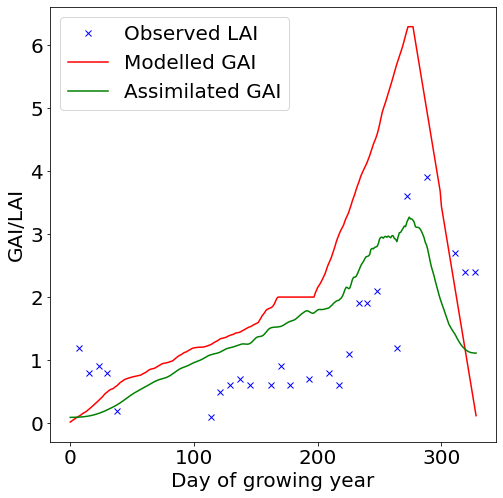

         Current function value: 6003.113410
         Iterations: 327
         Function evaluations: 532
         Gradient evaluations: 520
Processing obs point 1 of 3
Processing obs point 2 of 3
Processing obs point 3 of 3


<Figure size 432x288 with 0 Axes>

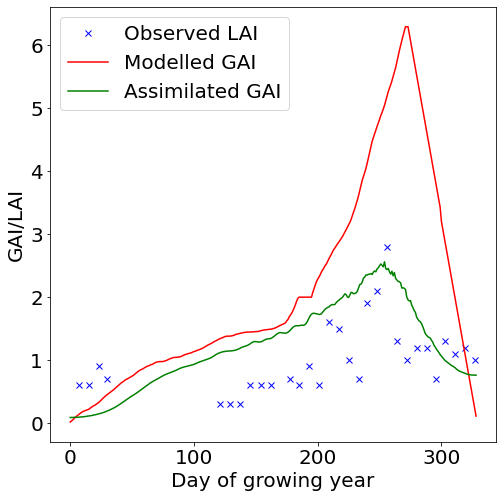

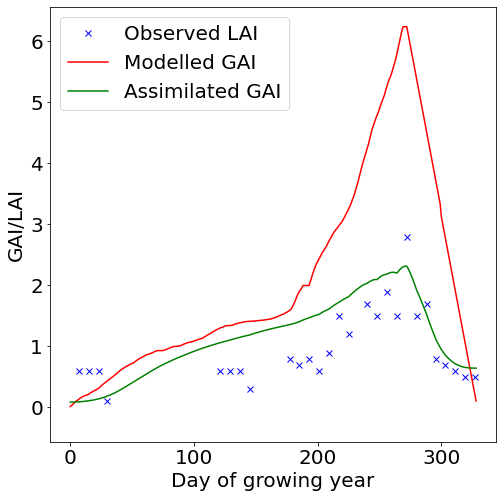

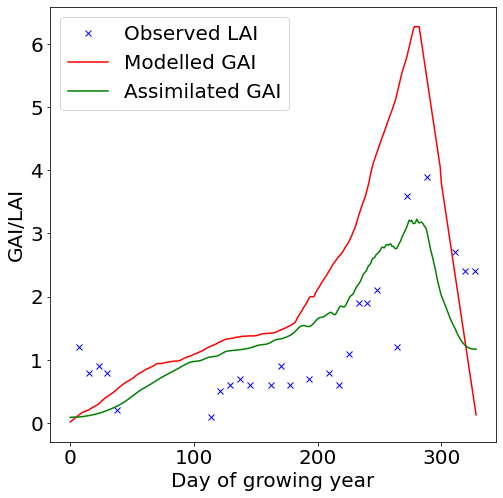

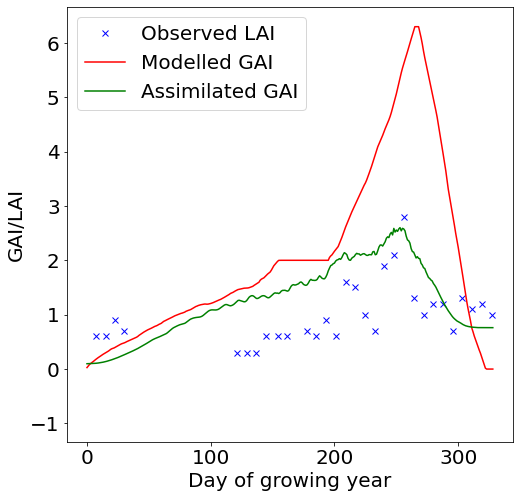

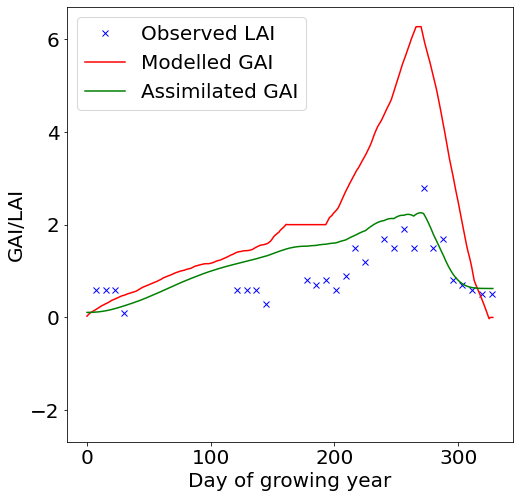

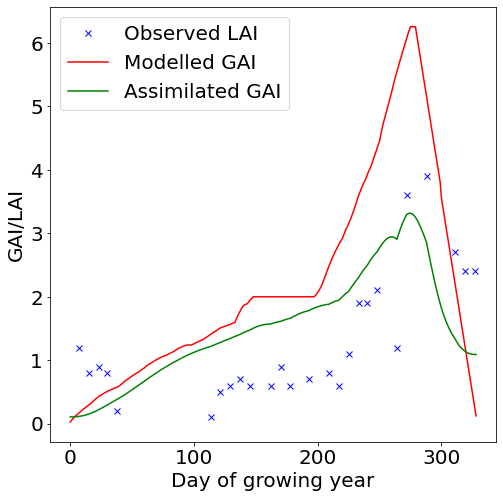

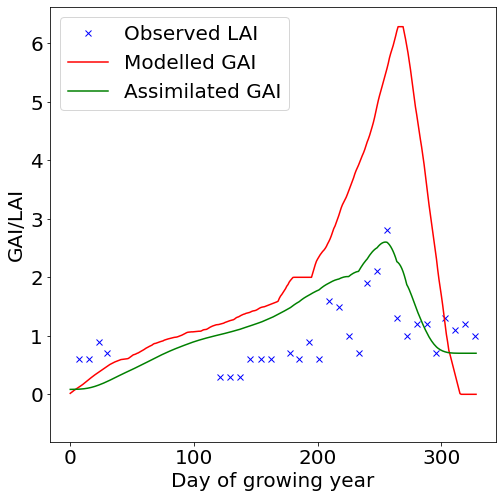

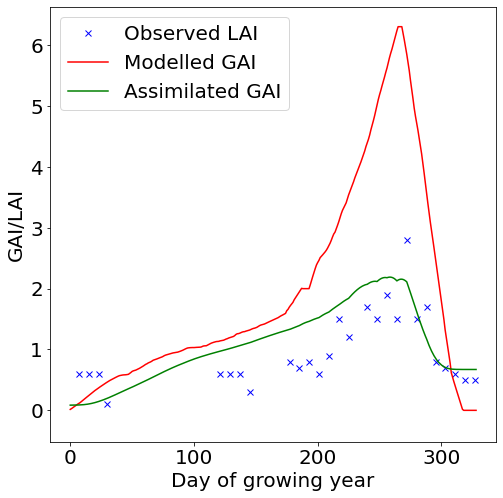

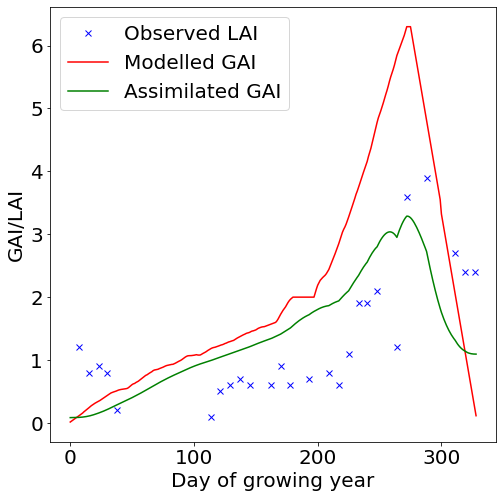

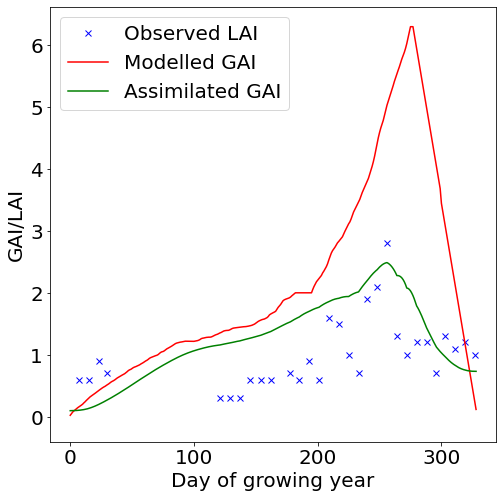

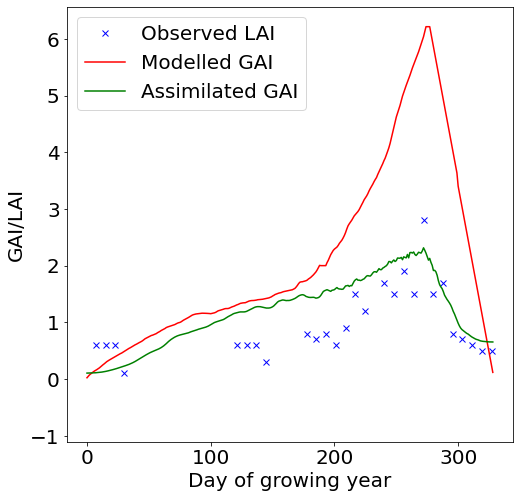

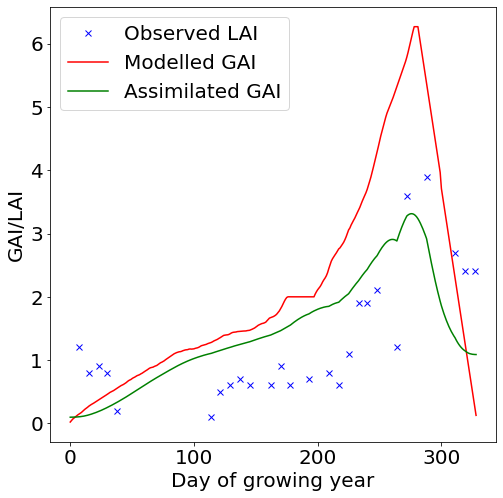

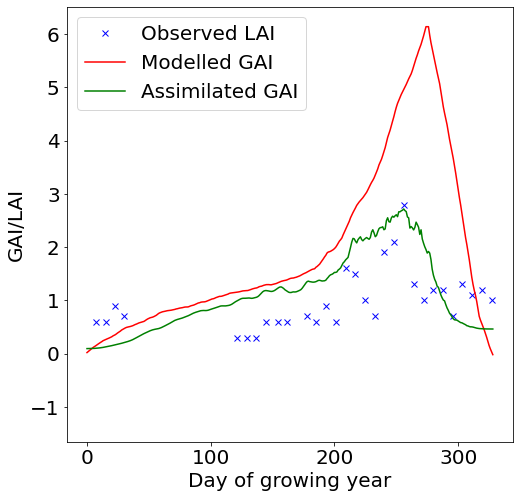

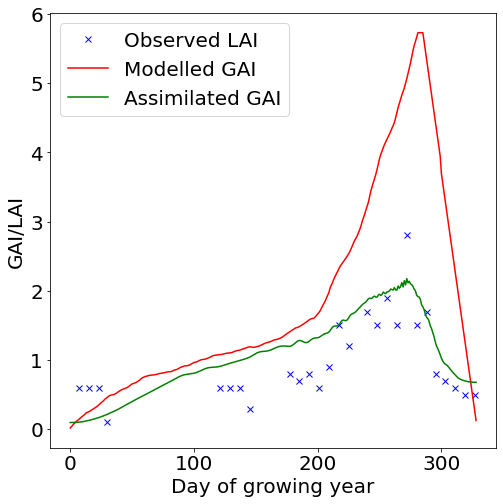

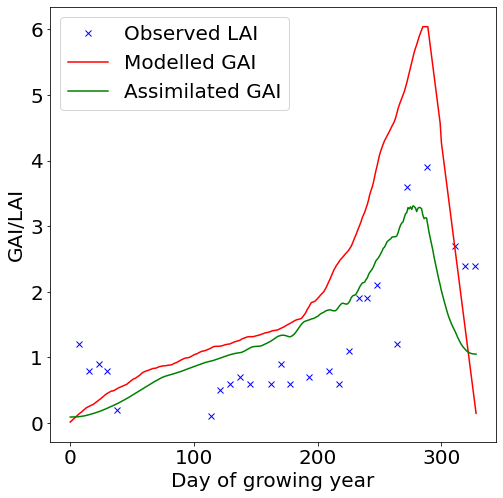

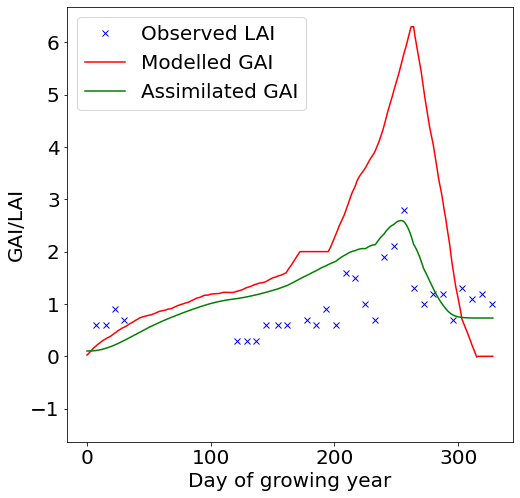

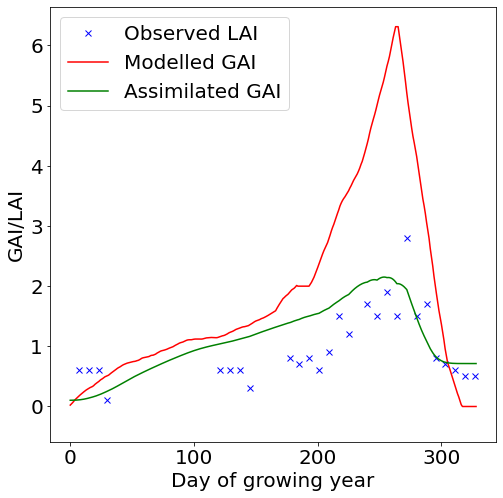

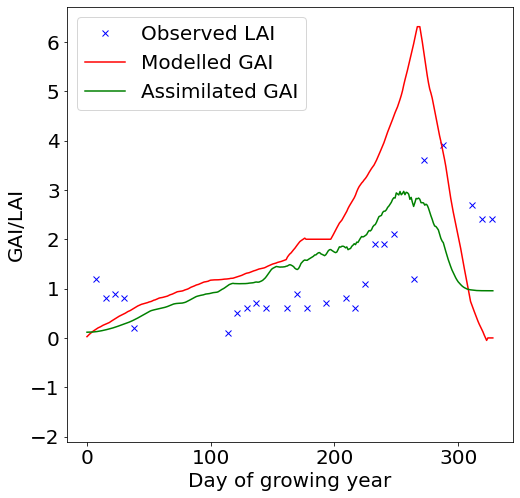

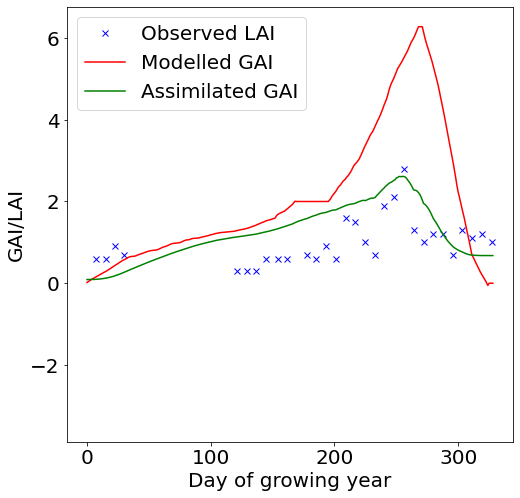

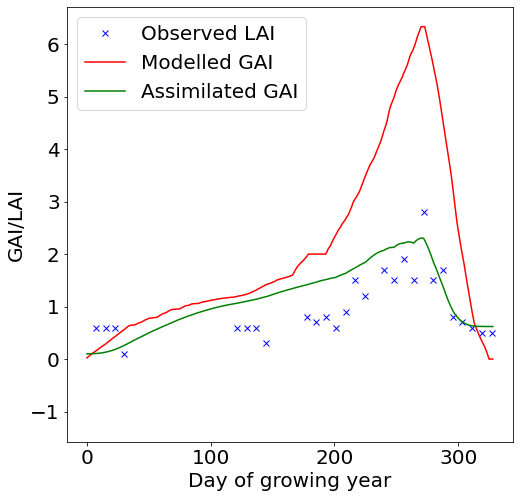

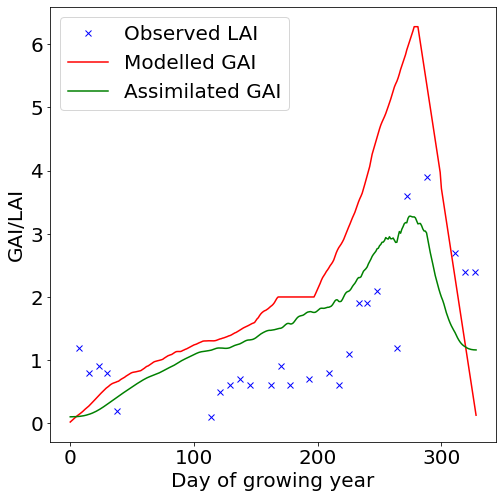

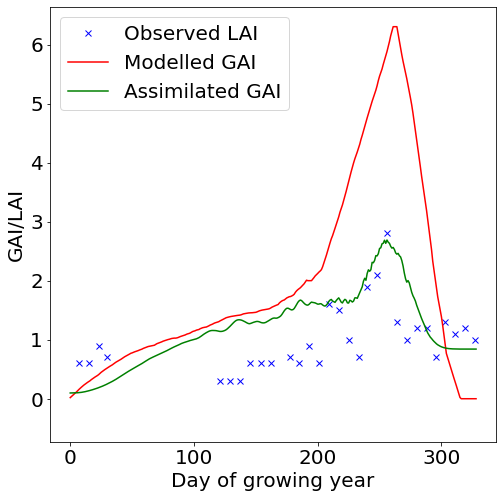

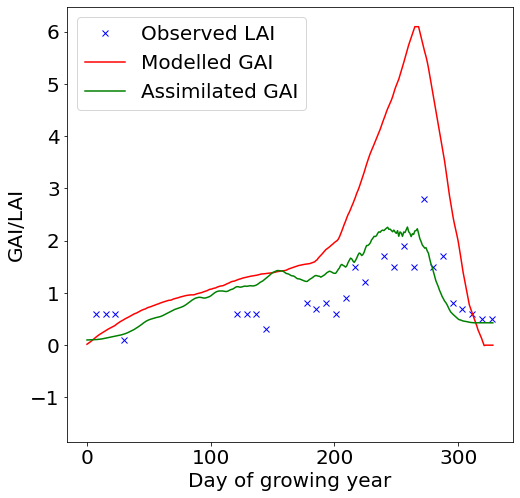

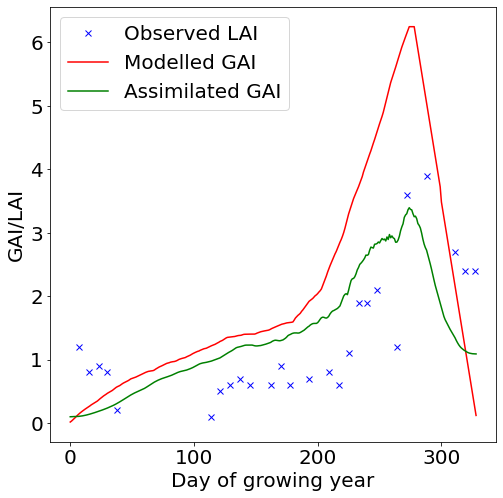

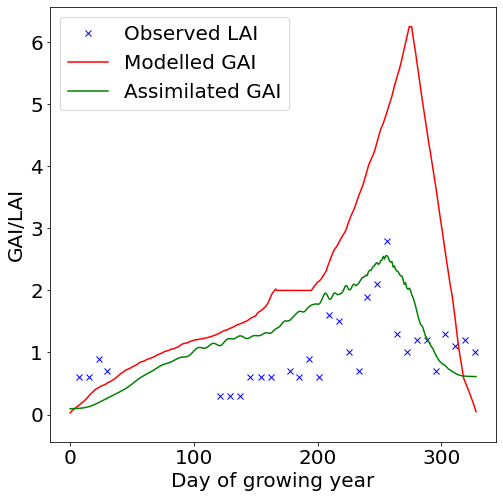

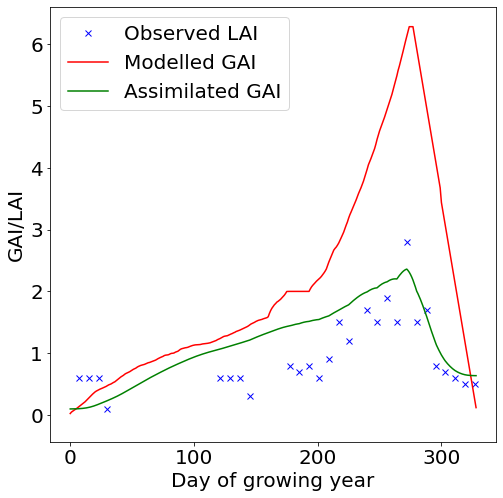

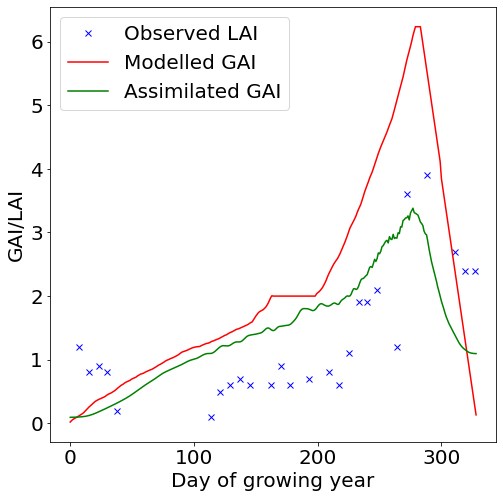

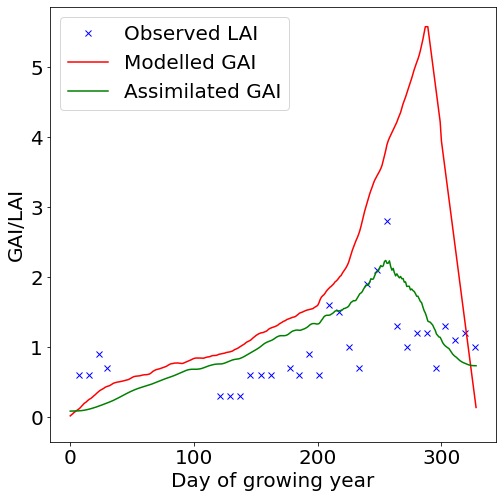

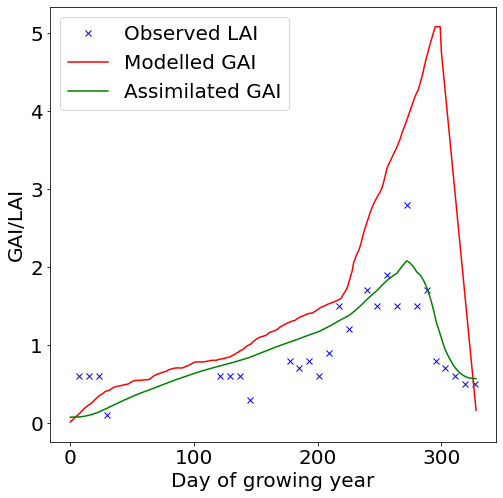

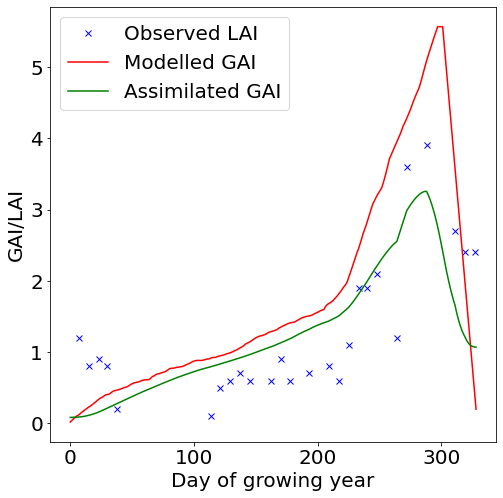

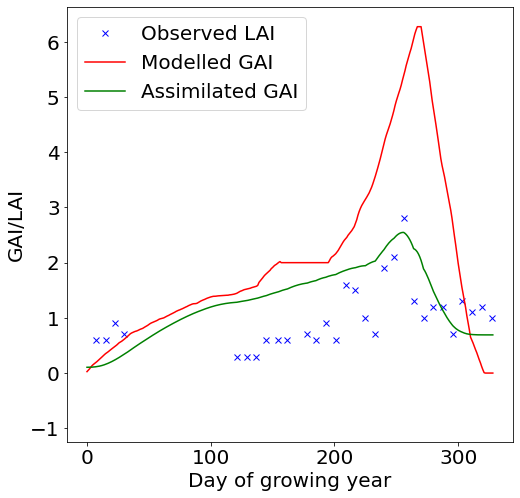

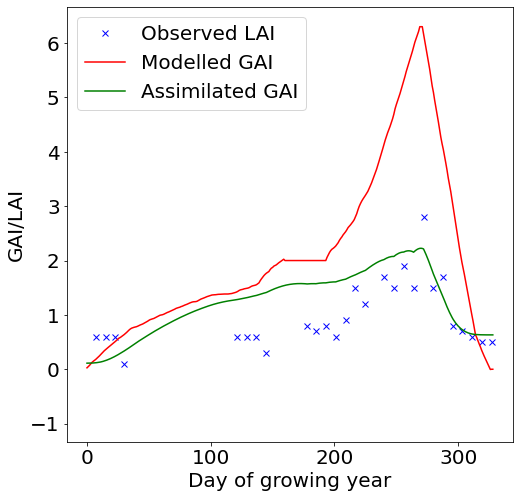

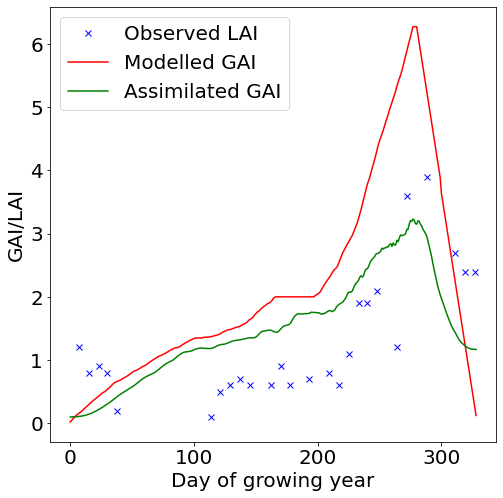

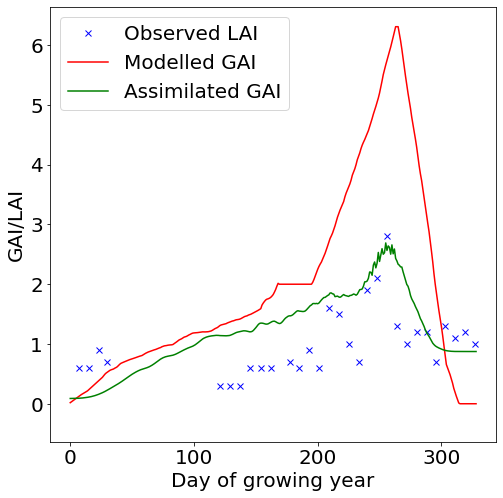

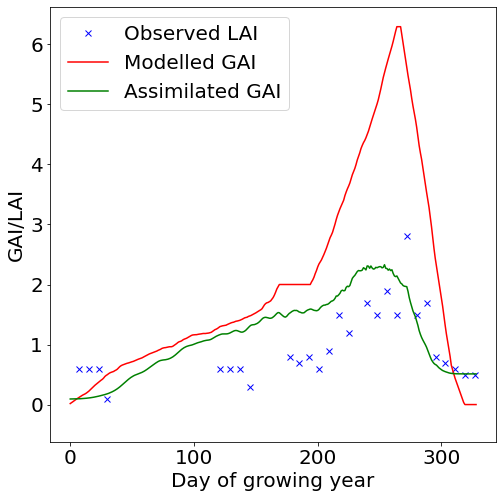

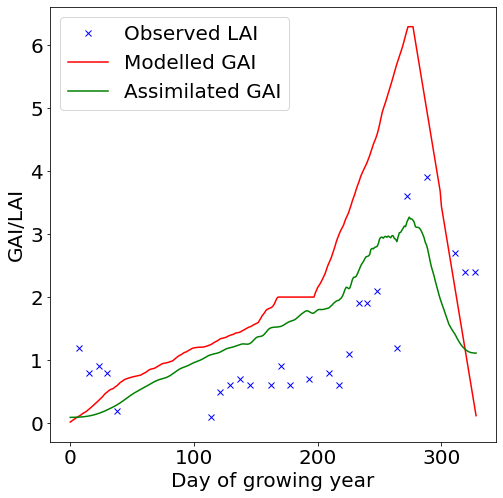

In [6]:
# now we've done the ensgen, do the assimilation                                                                      
cfxrs_vari = []
for ensmem in ensmems:
    print('Doing DA for GAI using variational method for ensmem ' + ensmem)
    mergedall_vari, cfall_vari = vari_method_point(obspd, GAI_p_all.sel(ensmem=int(ensmem)), GAI_p_ensstd,
                                                   obscoords, year, ensmem, obserrtype, obserr, moderrinfl, 
                                                   tsvar, order, power, plot, plotdir, interval)

    cfxr_vari = cfall_vari.to_xarray()
    del cfall_vari
    cfxr_vari = cfxr_vari.expand_dims({'ensmem': [int(ensmem)]})
    cfxr_vari = xr.where(np.isinf(cfxr_vari), np.nan, cfxr_vari) # set infs as nans                                   
    cfxrs_vari.append(cfxr_vari)
    
    oldyields, newyields = update_yield_points_point(GAI_p_all.sel(ensmem=int(ensmem)), mergedall_vari, obscoords,
                                 tmean_p_all.sel(ensmem=int(ensmem)), prec_p_all.sel(ensmem=int(ensmem)),
                                 solarrad_p_all.sel(ensmem=int(ensmem)), Jarray_p_all.sel(ensmem=int(ensmem)),
                                 Cday_p_all.sel(ensmem=int(ensmem)), GSS_p_all.sel(ensmem=int(ensmem)),
                                 HarvestJday, AWC_allp, temp_cconc, ensmem)

    del mergedall_vari
    counter=0
    for tob in obscoords:
        oldyields_vari[str(tob[0])+','+str(tob[1])].loc[dict(ensmem=int(ensmem), year=year)] = oldyields[counter]
        newyields_vari[str(tob[0])+','+str(tob[1])].loc[dict(ensmem=int(ensmem), year=year)] = newyields[counter]
        counter+=1

In [ ]:
cfallensmems_vari = xr.concat(cfxrs_vari, dim='ensmem')
cfyears_vari.append(cfallensmems_vari)

------------------